[Оригинальный notebook](https://www.kaggle.com/code/sharthz23/implicit-lightfm/notebook)

In [1]:
from collections import defaultdict
import os

import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender, TFIDFRecommender
from implicit.als import AlternatingLeastSquares
from implicit import gpu
from lightfm.data import Dataset
from lightfm import LightFM

Implicit ALS с GPU:

In [2]:
gpu.HAS_CUDA

True

In [3]:
sns.set_style("darkgrid")

In [4]:
%load_ext autoreload
%autoreload 2

from recs_utils.metrics import compute_metrics, model_cross_validate
from recs_utils.load_data import load_users, load_items, load_interactions, sample_true_rec_data
from recs_utils.simple_rec import PopularRecommender, PopularRecommenderPerAge
from recs_utils.split import train_test_split, TimeRangeSplit
from recs_utils.matrix_ops import interactions_to_csr_matrix
from recs_utils.implicit_model import ImplicitRecommender, LightFMRecommender

# Подготовка данных

In [5]:
data_dir = "data"

In [6]:
df = load_interactions(os.path.join(data_dir, "interactions.csv"))
df_users = load_users(os.path.join(data_dir, "users.csv"))
df_items = load_items(os.path.join(data_dir, "items.csv"))

In [7]:
df_items.head()

,title,genres,authors,year
item_id,,,,
128115,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
210979,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
95632,Испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869
247906,Странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831
294280,Господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873


In [8]:
users_inv_mapping = dict(enumerate(df.index.unique("user_id")))
users_mapping = {v: k for k, v in users_inv_mapping.items()}
len(users_mapping)

151600

In [9]:
items_inv_mapping = dict(enumerate(df.index.unique("item_id")))
items_mapping = {v: k for k, v in items_inv_mapping.items()}
len(items_mapping)

59599

In [10]:
df_items["title"] = df_items["title"].str.strip().str.lower()

In [11]:
item_titles = pd.Series(df_items['title'], index=df_items.index).to_dict()
len(item_titles), item_titles[128115]

(59599, 'ворон-челобитчик')

In [12]:
df_items.reset_index().head()

,item_id,title,genres,authors,year
0,128115,ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,210979,скрипка ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2,95632,испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869
3,247906,странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831
4,294280,господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873


In [13]:
title_items = df_items.reset_index().groupby('title')["item_id"].agg(list)
title_items.head(n=4)

title
# 20 восьмая       [201623]
# duo               [72582]
# me too. роман    [171172]
# партия           [224512]
Name: item_id, dtype: object

In [14]:
title_count = title_items.map(len)
title_count.value_counts()

item_id
1     55708
2      1197
3       245
4        71
5        38
6        11
7         8
8         3
9         2
18        1
11        1
13        1
23        1
12        1
47        1
Name: count, dtype: int64

In [15]:
title_items[title_count > 1].tail()

title
яма                                              [60156, 165785]
янки из коннектикута при дворе короля артура      [14759, 56530]
японская диета                                   [168986, 74652]
яр                                                [168761, 5371]
ящик пандоры                                    [236465, 158851]
Name: item_id, dtype: object

In [16]:
df_items[df_items['title'] == 'ящик пандоры']

,title,genres,authors,year
item_id,,,,
236465,ящик пандоры,"Любовно-фантастические романы,Научная фантастика",Филипп Хорват,2017
158851,ящик пандоры,"Мистика,Современная зарубежная литература",Бернар Вербер,2018


In [17]:
title_items[title_count > 1].head()

title
(о переводе)                 [61213, 145263]
2084                        [177082, 281410]
451 градус по фаренгейту     [44681, 162716]
playboy 02-2018               [114405, 8599]
playboy 03-2018              [31097, 121747]
Name: item_id, dtype: object

In [18]:
df_items[df_items['title'] == '451 градус по фаренгейту']

,title,genres,authors,year
item_id,,,,
44681,451 градус по фаренгейту,"Социальная фантастика,Зарубежная фантастика,На...",Рэй Брэдбери,1953
162716,451 градус по фаренгейту,"Социальная фантастика,Зарубежная фантастика,На...",Рэй Брэдбери,"1951, 1953, 1967"


In [19]:
df.head(n=3)

,,progress,rating,start_date
user_id,item_id,,,
126706,14433,80,NaN,2018-01-01
127290,140952,58,NaN,2018-01-01
66991,198453,89,NaN,2018-01-01


In [20]:
df['rating'] = df['rating'].to_numpy(dtype=np.float32)

df.loc[(slice(None), [44681, 162716]), :].groupby('item_id').agg({
    'progress': np.size,
    'rating': ['mean', "min", "max"],
    'start_date': ['min', 'max'],
})

progress rating           start_date           
            size   mean  min  max        min        max
item_id                                                
44681        353   4.56  1.0  5.0 2018-01-24 2019-12-20
162716        59   4.80  4.0  5.0 2018-01-25 2019-12-30

In [21]:
last_date = df['start_date'].max().normalize()
folds = 7
start_date = last_date - pd.Timedelta(days=folds)
start_date, last_date

(Timestamp('2019-12-24 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [22]:
cv = TimeRangeSplit(start_date=start_date, periods=folds + 1)

cv.max_n_splits, cv.get_n_splits(df, datetime_column='start_date')

(7, 7)

In [23]:
cv.date_range

DatetimeIndex(['2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27',
               '2019-12-28', '2019-12-29', '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', freq='D')

In [24]:
folds_with_stats = list(cv.split(
    df, 
    user_column='user_id',
    item_column='item_id',
    datetime_column='start_date',
    fold_stats=True
)
)

folds_info_with_stats = pd.DataFrame([info for _, _, info in folds_with_stats])

In [25]:
folds_info_with_stats

,Start date,End date,Train,New users,New users interactions,New items,New items interactions,Known interactions,Test
0,2019-12-24,2019-12-25,1515946,3,3,0,0,0,2045
1,2019-12-25,2019-12-26,1517994,1,1,0,0,0,2141
2,2019-12-26,2019-12-27,1520136,0,0,0,0,0,2177
3,2019-12-27,2019-12-28,1522313,0,0,0,0,0,2110
4,2019-12-28,2019-12-29,1524423,2,4,0,0,0,2205
5,2019-12-29,2019-12-30,1526632,4,4,0,0,0,2118
6,2019-12-30,2019-12-31,1528754,1,1,0,0,0,2168


In [26]:
top_N = 10

# Implicit

In [27]:
train_idx, test_idx, info = folds_with_stats[0]

train = df.loc[train_idx, :]
test = df.loc[test_idx, :]
train.shape, test.shape

((1515946, 3), (2045, 3))

In [28]:
cosine_model = ImplicitRecommender(CosineRecommender(K=10), users_mapping, items_mapping, items_inv_mapping)

In [29]:
cosine_model.fit(train)

/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008523702621459961 seconds
  warnings.warn(


  0%|          | 0/59599 [00:00<?, ?it/s]

In [30]:
user_id = test.index.get_level_values("user_id")[0]
print(f'Рекомендации для пользователя {user_id}')

Рекомендации для пользователя 139942


In [31]:
pred_recs = cosine_model.recommend([user_id], n=top_N)

In [32]:
pred_recs

rank
user_id item_id      
139942  193358      1
        125586      2
        203882      3
        90986       4
        146180      5
        264849      6
        238155      7
        7094        8
        1728        9
        240226     10

In [33]:
test.head()

,,progress,rating,start_date
user_id,item_id,,,
139942,26270,58,NaN,2019-12-24
136607,82392,39,NaN,2019-12-24
142287,84446,79,NaN,2019-12-24
114933,319155,9,NaN,2019-12-24
32926,120339,73,NaN,2019-12-24


In [34]:
pred_recs = cosine_model.recommend(test.index.get_level_values("user_id").unique(), n=top_N)

In [35]:
pred_recs.head(top_N + 3)

rank
user_id item_id      
139942  193358      1
        125586      2
        203882      3
        90986       4
        146180      5
        264849      6
        238155      7
        7094        8
        1728        9
        240226     10
136607  250158      1
        121182      2
        141120      3

In [36]:
pred_recs.loc[(user_id, slice(None)), :]

rank
user_id item_id      
139942  193358      1
        125586      2
        203882      3
        90986       4
        146180      5
        264849      6
        238155      7
        7094        8
        1728        9
        240226     10

In [37]:
metrics = compute_metrics(test, pred_recs, top_N)

In [38]:
metrics

,value
name,
prec@1,0.011628
recall@1,0.010200
prec@2,0.010098
recall@2,0.018054
prec@3,0.009384
recall@3,0.024057
prec@4,0.007956
recall@4,0.026811
prec@5,0.007222


In [39]:
def create_cosine_model():
    return ImplicitRecommender(CosineRecommender(K=top_N), users_mapping, items_mapping, items_inv_mapping)


def create_bm25():
    return ImplicitRecommender(BM25Recommender(K=top_N), users_mapping, items_mapping, items_inv_mapping)

def create_tfidf():
    return ImplicitRecommender(TFIDFRecommender(K=top_N), users_mapping, items_mapping, items_inv_mapping)

def create_alsm():
    return ImplicitRecommender(AlternatingLeastSquares(factors=32, iterations=10), users_mapping, items_mapping, items_inv_mapping)

In [40]:
cv_res_per_model = []
models = {}

In [87]:
for factory in (create_cosine_model, create_bm25, create_tfidf, create_alsm):
    cross_valid_res_model, model = model_cross_validate(
        df, 
        user_features=df_users, 
        item_features=df_items, 
        folds=folds_with_stats, 
        model_factory=factory, 
        n=top_N)
    models[model.model_name()] = model
    cv_res_per_model.append(cross_valid_res_model)
    del cross_valid_res_model

  0%|          | 0/7 [00:00<?, ?it/s]

/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00838017463684082 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008441686630249023 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008302450180053711 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.01039266586303711 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/imp

  0%|          | 0/7 [00:00<?, ?it/s]

/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.009989738464355469 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008583784103393555 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007918119430541992 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00792837142944336 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/im

  0%|          | 0/7 [00:00<?, ?it/s]

/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008374929428100586 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.009269237518310547 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008784055709838867 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.014273643493652344 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/i

  0%|          | 0/7 [00:00<?, ?it/s]

In [88]:
cross_valid_res = pd.concat(cv_res_per_model)
cv_res_per_model.clear()

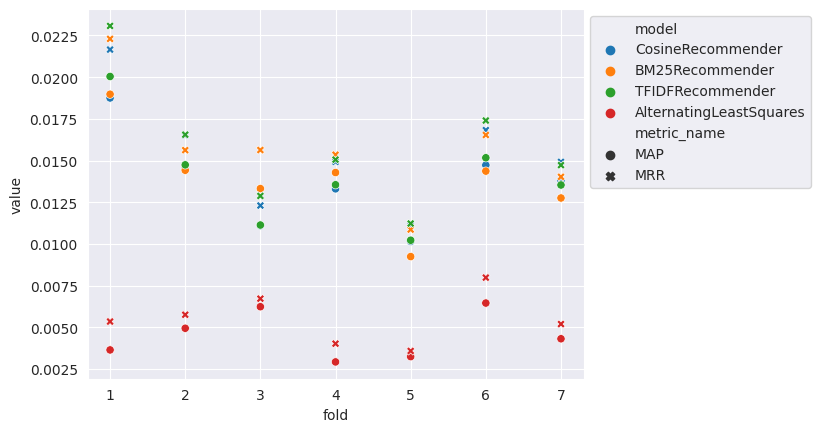

In [89]:
ax = sns.scatterplot(cross_valid_res[cross_valid_res["metric_name"].isin(["MAP", "MRR"])], x="fold", y="value", style="metric_name", hue="model")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [44]:
cross_valid_res.pivot(index=["fold", "model"], columns=["metric_name"], values=["value"]).droplevel(level=0, axis="columns").groupby("model").agg(
    {
    "MRR": ['mean', 'std', 'min', 'max'],
    'MAP': ['mean', 'std', 'min', 'max'],
    f'recall@{top_N}': ['mean', 'std', 'min', 'max'],
    }
)

metric_name                   MRR                                     MAP   
                             mean       std       min       max      mean   
model                                                                       
AlternatingLeastSquares  0.005003  0.001139  0.003245  0.006931  0.004136  \
BM25Recommender          0.015761  0.003428  0.010862  0.022296  0.013909   
CosineRecommender        0.015466  0.003430  0.011132  0.021653  0.013770   
TFIDFRecommender         0.015844  0.003811  0.011226  0.023071  0.014056   

metric_name                                           recall@10             
                              std       min       max      mean       std   
model                                                                       
AlternatingLeastSquares  0.001083  0.003027  0.005788  0.010705  0.001767  \
BM25Recommender          0.002879  0.009243  0.018977  0.029273  0.004234   
CosineRecommender        0.002792  0.010155  0.018753  0.029178  0.006035   
TFIDFRecommender         0.003195  0.010224  0.020040  0.029277  0.005309   

metric_name                                  
                              min       max  
model                                        
AlternatingLeastSquares  0.008491  0.013732  
BM25Recommender          0.024603  0.037113  
CosineRecommender        0.023708  0.039139  
TFIDFRecommender         0.023529  0.037929

In [45]:
models.keys()

dict_keys(['CosineRecommender', 'BM25Recommender', 'TFIDFRecommender', 'AlternatingLeastSquares'])

In [46]:
similiar_items = models["TFIDFRecommender"].similiar_items([60193], top_N)

In [47]:
similiar_items["orig_title"] = similiar_items["item_id"].map(item_titles.get)
similiar_items["sim_titles"] = similiar_items["similiar_item_id"].map(item_titles.get)

In [48]:
similiar_items

,item_id,similiar_item_id,score,orig_title,sim_titles
0,60193,60193,1.000000,мастер и маргарита,мастер и маргарита
1,60193,252228,0.085901,мастер и маргарита,мастер и маргарита (иллюстрированное издание)
2,60193,283431,0.057461,мастер и маргарита,мастер и маргарита краткий пересказ произведен...
3,60193,106146,0.038287,мастер и маргарита,без имени
4,60193,129959,0.034565,мастер и маргарита,белая гвардия. мастер и маргарита (иллюстриров...
5,60193,229856,0.033712,мастер и маргарита,"булгаков и «маргарита», или история несчастной..."
6,60193,284757,0.033223,мастер и маргарита,стори 11-2015
7,60193,214968,0.032520,мастер и маргарита,драгоценная плоть
8,60193,303726,0.031764,мастер и маргарита,ничего не возьму с собой
9,60193,9282,0.031390,мастер и маргарита,идущий на север. долина башен


# LightFM

In [49]:
dataset = Dataset()

In [50]:
dataset.fit(df.index.get_level_values("user_id").unique(), df.index.get_level_values("item_id").unique())

In [51]:
lfm_df_users = df_users.copy()
lfm_df_items = df_items.copy()

In [52]:
lfm_df_users['age'] = lfm_df_users['age'].cat.add_categories('age_unknown')
lfm_df_users['age'] = lfm_df_users['age'].fillna('age_unknown')
age_features = lfm_df_users['age'].unique()
age_features

['45_54', '18_24', '65_inf', '35_44', '55_64', '25_34', 'age_unknown']
Categories (7, object): ['18_24', '25_34', '35_44', '45_54', '55_64', '65_inf', 'age_unknown']

In [53]:
lfm_df_users['sex'] = np.array(lfm_df_users['sex'].astype(str))
lfm_df_users['sex'] = lfm_df_users['sex'].fillna('sex_unknown')
sex_features = lfm_df_users['sex'].unique()
sex_features

array(['nan', '0.0', '1.0'], dtype=object)

In [54]:
users_features = np.append(age_features, sex_features)
users_features

array(['45_54', '18_24', '65_inf', '35_44', '55_64', '25_34',
       'age_unknown', 'nan', '0.0', '1.0'], dtype=object)

In [55]:
dataset.fit_partial(user_features=users_features)

In [56]:
lfm_df_items['genres'] = lfm_df_items['genres'].cat.add_categories('genre_unknown')
lfm_df_items['genres'] = lfm_df_items['genres'].fillna('genre_unknown')
genres = list(lfm_df_items['genres'].str.split(',').explode().unique())
len(genres)

641

In [57]:
dataset.fit_partial(item_features=genres)

In [58]:
num_users, num_items = dataset.interactions_shape()
num_users, num_items

(151600, 59599)

In [59]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('users_mapping len - ', len(lightfm_mapping['users_mapping']))
print('user_features_mapping len - ', len(lightfm_mapping['user_features_mapping']))
print('items_mapping len - ', len(lightfm_mapping['items_mapping']))
print('Users item_features_mapping len - ', len(lightfm_mapping['item_features_mapping']))

users_mapping len -  151600
user_features_mapping len -  151610
items_mapping len -  59599
Users item_features_mapping len -  60240


In [60]:
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [61]:
num_user_features = dataset.user_features_shape()
num_show_features = dataset.item_features_shape()
print('Num user features: {} -> {}\nnum item features: {} -> {}.'.format(
    num_user_features[1] - num_users, num_user_features[1], 
    num_show_features[1] - num_items, num_show_features[1]))

Num user features: 10 -> 151610
num item features: 641 -> 60240.


In [62]:
train_idx, test_idx, info = folds_with_stats[0]

train = df.loc[train_idx]
test = df.loc[test_idx]

In [63]:
train_mat, train_mat_weights = dataset.build_interactions(train.index)
train_mat

<151600x59599 sparse matrix of type '<class 'numpy.int32'>'
	with 1515946 stored elements in COOrdinate format>

In [64]:
train_mat_weights

<151600x59599 sparse matrix of type '<class 'numpy.float32'>'
	with 1515946 stored elements in COOrdinate format>

In [65]:
lfm_df_users['features'] = lfm_df_users[['age', 'sex']].astype(str).apply(lambda x: list(x), axis=1)
lfm_df_users.head()

,age,sex,features
user_id,,,
1,45_54,nan,"[45_54, nan]"
2,18_24,0.0,"[18_24, 0.0]"
3,65_inf,0.0,"[65_inf, 0.0]"
4,18_24,0.0,"[18_24, 0.0]"
5,35_44,0.0,"[35_44, 0.0]"


In [66]:
known_users_mask = lfm_df_users.index.get_level_values("user_id").isin(df.index.get_level_values("user_id").unique())

train_user_features = dataset.build_user_features(
    lfm_df_users.loc[known_users_mask]['features'].items()
)
train_user_features

<151600x151610 sparse matrix of type '<class 'numpy.float32'>'
	with 422954 stored elements in Compressed Sparse Row format>

In [67]:
lfm_df_items['features'] = lfm_df_items['genres'].str.split(',')
lfm_df_items.head()

,title,genres,authors,year,features
item_id,,,,,
128115,ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886,"[Зарубежные детские книги, Сказки, Зарубежная ..."
210979,скрипка ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894,"[Классическая проза, Литература 19 века, Русск..."
95632,испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869,"[Зарубежная классика, Классическая проза, Лите..."
247906,странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831,"[Пьесы и драматургия, Литература 19 века]"
294280,господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873,"[Зарубежная классика, Классическая проза, Лите..."


In [68]:
lfm_df_items['features'].map(len).value_counts(dropna=False)

features
2     20734
1     20172
3     12699
4      4248
5      1074
6       373
7       146
8        74
9        34
10       22
11       12
13        6
12        2
17        2
16        1
Name: count, dtype: int64

In [69]:
known_items_mask = lfm_df_items.index.get_level_values('item_id').isin(df.index.get_level_values('item_id').unique())

train_items_features = dataset.build_item_features(
        lfm_df_items.loc[known_items_mask]["features"].items()
)
train_items_features

<59599x60240 sparse matrix of type '<class 'numpy.float32'>'
	with 186360 stored elements in Compressed Sparse Row format>

In [70]:
lfm_model = LightFM(no_components=64, learning_rate=0.05, loss='warp', max_sampled=5, random_state=23)

In [71]:
num_epochs = 5

for _ in trange(num_epochs):
    lfm_model.fit_partial(
        train_mat, 
        user_features=train_user_features,
        item_features=train_items_features,
        num_threads=4
    )

  0%|          | 0/5 [00:00<?, ?it/s]

In [72]:
user_id = test.index.get_level_values("user_id")[0]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Рекомендации для пользователя {user_id}, номер строки - {row_id}')

Рекомендации для пользователя 139942, номер строки - 10346


In [73]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

59599

In [74]:
pred = lfm_model.predict(row_id, all_cols, user_features=train_user_features, item_features=train_items_features)
pred, pred.shape

(array([-101.566025, -102.206276, -102.384476, ..., -102.99845 ,
        -102.82235 , -102.66293 ], dtype=float32),
 (59599,))

In [75]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 4681,  1833, 27841,  4059,   684,   465,  1075,  1258,   443,
       30764])

In [76]:
pred[top_cols]

array([-98.23288 , -98.570274, -98.675674, -98.68404 , -98.8119  ,
       -98.81601 , -98.81661 , -98.83992 , -98.84854 , -98.87332 ],
      dtype=float32)

In [77]:
pred.max()

-98.23288

In [78]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_titles.get)
recs

,col_id,item_id,title
0,4681,99357,"сила подсознания, или как изменить жизнь за 4 ..."
1,1833,281005,"богатый папа, бедный папа. роберт кийосаки (об..."
2,27841,211217,"ни сы. восточная мудрость, которая гласит: буд..."
3,4059,90519,думай медленно… решай быстро
4,684,308529,игра престолов. часть i
5,465,58803,ведьмак
6,1075,24551,магическая уборка. японское искусство наведени...
7,1258,89152,50 правил умной дуры
8,443,26963,шантарам
9,30764,32603,игра престолов


In [79]:
def create_lightfm():
    return LightFMRecommender(
        LightFM(
            no_components=64, 
            learning_rate=0.05, 
            loss='warp', 
            max_sampled=5, 
            random_state=23),
             num_epoch=15,
             num_threads=4)

In [90]:
for factory in (create_lightfm, ):
    cross_valid_res_model, model = model_cross_validate(
        df, 
        user_features=df_users, 
        item_features=df_items, 
        folds=folds_with_stats, 
        model_factory=factory, 
        n=top_N)
    models[model.model_name()] = model
    cv_res_per_model.append(cross_valid_res_model)
    del cross_valid_res_model

  0%|          | 0/7 [00:00<?, ?it/s]

In [91]:
cross_valid_res = pd.concat([cross_valid_res] + cv_res_per_model)
cv_res_per_model.clear()

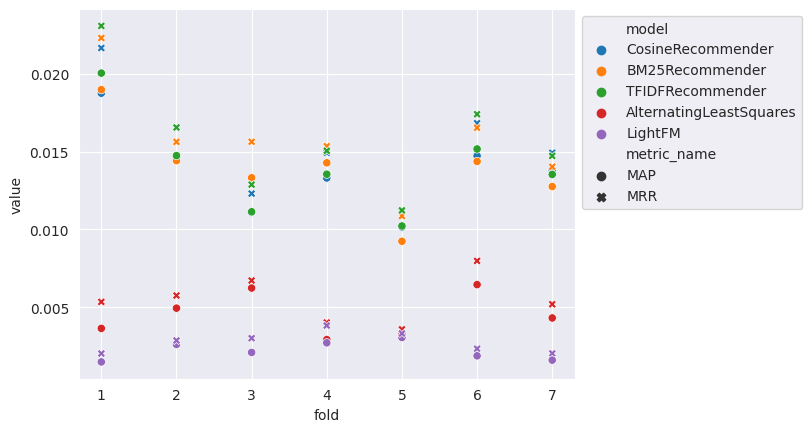

In [92]:
ax = sns.scatterplot(cross_valid_res[cross_valid_res["metric_name"].isin(["MAP", "MRR"])], x="fold", y="value", style="metric_name", hue="model")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))